### Kaggle.com – Digits Recognition – Softmax Version
https://www.kaggle.com/c/digit-recognizer

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# input features
x = tf.placeholder(tf.float32, shape=[None, 784])

In [3]:
# weights, biases
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

In [4]:
# model (predicted labels)
y = tf.nn.softmax(tf.matmul(x, W) + b)

In [5]:
# known labels
y_ = tf.placeholder(tf.float32, [None, 10])

In [6]:
# loss fn == avg(y'*log(y))
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

In [7]:
# how to train it
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [59]:
# read features
def read_features_from_csv(filename, usecols=range(1,785)):
    features = np.genfromtxt(filename, delimiter=',', skip_header=1, usecols=usecols, dtype=np.float32)
    features = np.divide(features, 255.0) # scale 0..255 to 0..1
    return features

# read labels and convert them to 1-hot vectors
def read_labels_from_csv(filename):
    labels_orig = np.genfromtxt(filename, delimiter=',', skip_header=1, usecols=0, dtype=np.int)
    labels = np.zeros([len(labels_orig), 10])
    labels[np.arange(len(labels_orig)), labels_orig] = 1
    labels = labels.astype(np.float32)
    return labels

In [9]:
# generate batches
def generate_batch(features, labels, batch_size):
    batch_indexes = np.random.random_integers(0, len(features) - 1, batch_size)
    batch_features = features[batch_indexes]
    batch_labels = labels[batch_indexes]
    return (batch_features, batch_labels)

In [10]:
# read features & labels
features = read_features_from_csv('train.csv')
labels = read_labels_from_csv('train.csv')

In [18]:
# training parameters
BATCH_SIZE = 1000
TRAIN_SPLIT=0.75 # how much data to use for training (vs validation)
TRAINING_STEPS = int(len(features) * TRAIN_SPLIT / BATCH_SIZE * 150) # multiply for better coverage

In [19]:
# split data into training and validation sets
train_samples = int(len(features) / (1 / TRAIN_SPLIT))
train_features = features[:train_samples]
train_labels = labels[:train_samples]
validation_features = features[train_samples:]
validation_labels = labels[train_samples:]

In [20]:
# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def _get_accuracy():
    return sess.run(accuracy, feed_dict={x: validation_features, y_: validation_labels})

In [50]:
# init tf stuff
init = tf.initialize_all_variables();
sess = tf.Session();
sess.run(init);

In [51]:
# train

accuracy_history = []

for i in range(TRAINING_STEPS):
    accuracy_val = _get_accuracy()
    accuracy_history.append(accuracy_val)
        
    if i == 0 or (i + 1) % (TRAINING_STEPS // 10) == 0 or (i + 1) == TRAINING_STEPS:
        print 'step', i + 1, 'of', TRAINING_STEPS, '/ val accuracy:', accuracy_val
        
    batch_xs, batch_ys = generate_batch(train_features, train_labels, BATCH_SIZE)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

step 1 of 4725 / val accuracy: 0.101238
step 472 of 4725 / val accuracy: 0.913142
step 944 of 4725 / val accuracy: 0.917619
step 1416 of 4725 / val accuracy: 0.918571
step 1888 of 4725 / val accuracy: 0.920285
step 2360 of 4725 / val accuracy: 0.91819
step 2832 of 4725 / val accuracy: 0.919999
step 3304 of 4725 / val accuracy: 0.920476
step 3776 of 4725 / val accuracy: 0.921523
step 4248 of 4725 / val accuracy: 0.92019
step 4720 of 4725 / val accuracy: 0.920761
step 4725 of 4725 / val accuracy: 0.920666


**Validation accuracy over the training steps:**

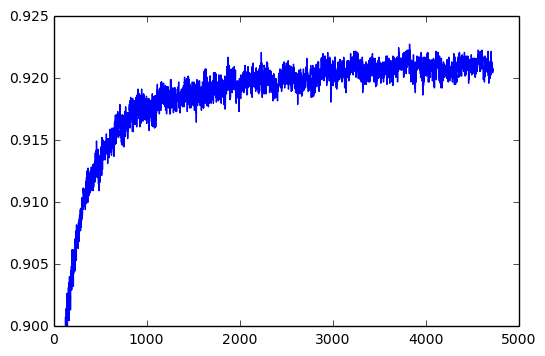

In [58]:
plt.gca().set_ylim(bottom=0.9, top=0.925)
plt.plot(accuracy_history)

In [60]:
# read test data
test_features = read_features_from_csv('test.csv', usecols=None)

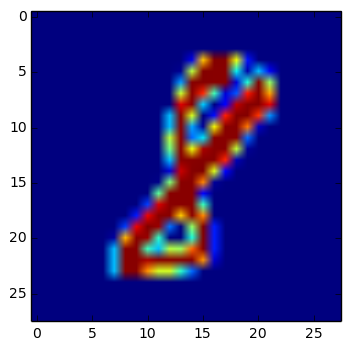

In [116]:
# validate one image

test_index = 123
plt.imshow(np.reshape(test_features[test_index], (28, 28)))

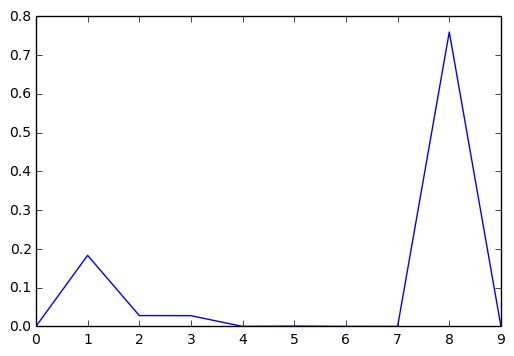

In [122]:
# run model on single image
predicted_labels = sess.run(y, feed_dict={x: [test_features[test_index]]})
plt.plot(predicted_labels[0])

In [ ]:
# looks fine!

#### Create Submission File

In [146]:
# run model on test data
predicted_labels = sess.run(y, feed_dict={x: test_features})

# convert softmax predictions to label
predicted_labels = np.argmax(predicted_labels, axis=1)

In [147]:
# add digit ids
predicted_labels = [np.arange(1,1+len(predicted_labels)), predicted_labels]
predicted_labels = np.transpose(predicted_labels)

In [159]:
# write to csv file
np.savetxt('submission.csv', predicted_labels, fmt='%i,%i', header='ImageId,Label', comments='')